In [21]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

# 1 Preparation

In [2]:
embedding_file = "test/embeddings_complete.pickle"
expression_file = "datasets/GD660.GeneQuantRPKM.txt.gz"
test_set_file = "datasets/test_set_indices.tsv"

## 1.1 Embeddings

In [3]:
embeddings = pd.read_pickle(embedding_file)
len(embeddings)

10060

In [4]:
# combine 2 embeddings of father and mother for each individual
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    # combined_embedding = np.concatenate([embeddings[i][1], embeddings[i+1][1]]) # concatenate 2 embeddings.
    combined_embedding = np.array(embeddings[i][1] + embeddings[i+1][1]) # element-wise sum of 2 embeddings
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})

In [5]:
df.head()

,sample_id,gene_id,embedding
0,NA20795,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0..."
1,HG00260,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017..."
2,HG01632,ENSG00000176681.9,"[-0.0912664, 0.07260499, -0.07260455, 0.113591..."
3,HG00173,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829..."
4,HG00178,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0..."


Standard scaling the embeddings, since this is assumed by many objective functions (e.g. RBF kernel of SVMs or L1/L2 regularizers of linear models), see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [6]:
combined_embeddings = np.stack(df.embedding.values)
scaler = StandardScaler()
scaler.fit(combined_embeddings)
combined_embeddings = scaler.transform(combined_embeddings)

df.embedding = combined_embeddings.tolist()

## 1.2 Expression Data

In [8]:
expression = pd.read_csv(expression_file, sep="\t")
expression.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.9495,0.95837,0.51002,0.29422,0.2296,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000


In [11]:
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0] + "." + expression["sample_id"].str.split(".", expand=True)[1]

In [13]:
test_set = pd.read_csv(test_set_file, sep="\t")
expression.loc[expression.sample_id.isin(test_set.sample_id) & expression.Gene_Symbol.isin(test_set.seg_name), "test_set"] = True
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0]
data = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])
data.loc[data.test_set != True, "test_set"] = False

In [19]:
data.head()

,sample_id,gene_id,embedding,TargetID,Gene_Symbol,Chr,Coord,expression,test_set
0,NA20795,ENSG00000198502.5,"[-0.4423682391643524, -1.354062557220459, -0.1...",ENSG00000198502.5,ENSG00000198502.5,6,32498064,177.86778,False
1,HG00260,ENSG00000214425.1,"[-0.16618235409259796, -0.7082405686378479, -1...",ENSG00000214425.1,ENSG00000214425.1,17,43595264,0.48644,False
2,HG00173,ENSG00000238083.3,"[0.8837500810623169, 0.026987630873918533, 0.1...",ENSG00000238083.3,ENSG00000238083.3,17,44588877,6.83944,False
3,HG00178,ENSG00000229450.2,"[2.0465478897094727, -1.6262924671173096, -0.6...",ENSG00000229450.2,ENSG00000229450.2,4,120299287,0.08522,True
4,HG00158,ENSG00000179344.11,"[0.30784618854522705, 0.335724413394928, 1.751...",ENSG00000179344.11,ENSG00000179344.11,6,32636160,318.19590,False


In [19]:
df = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])
print(f"Number of samples for prediction expression: {len(df)}")
genes = df.gene_id.unique()
print(f"Number of genes: {len(genes)}")

Number of samples for prediction expression: 4830
Number of genes: 10


In [20]:
def train_model(df, gene, method="linear", k=5, n_iter_search=25):
    if method not in ["linear", "ridge", "lasso", "elasticnet", "svr"]:
        raise ValueError(f"Method {method} is not valid, must be linear, ridge, lasso, elasticnet or svr!")
    
    # prepare data
    y = df[df.gene_id==gene].expression.values
    X = np.stack(df[df.gene_id==gene].embedding.values)
    
    # setup k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=83)
    
    models = []
    results = []
    # iterate over k folds
    # print(f"Results (rvalues) of k-fold regression for gene {gene} using a {method} model:")
    for i, (train, test) in enumerate(kf.split(X)):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        # train the model
        if method=="linear":
            model = LinearRegression().fit(X_train, y_train)
        elif method=="ridge":
            # model = Ridge(alpha=0.05).fit(X_train, y_train)
            # hyperparameter tuning for alpha
            param_dist = {"alpha": stats.loguniform(1e-4, 1e1)}
            model = RandomizedSearchCV(Ridge(), param_distributions=param_dist, n_iter=n_iter_search)
            model.fit(X_train, y_train) 
        elif method=="lasso":
            # model = Lasso(alpha=1.0).fit(X_train, y_train)
            # hyperparameter tuning for alpha
            param_dist = {"alpha": stats.loguniform(1e-4, 1e1)}
            model = RandomizedSearchCV(Lasso(), param_distributions=param_dist, n_iter=n_iter_search)
            model.fit(X_train, y_train) 
        elif method=="elasticnet":
            model = ElasticNet(random_state=53).fit(X_train, y_train)
        else:
            # model = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1)).fit(X_train, y_train)
            # hyperparameter tuning for C, epsilon, kernel, gamma
            param_dist = {"C": stats.expon(scale=100),
                          "epsilon": stats.expon(scale=10),
                          "kernel": ["rbf", "poly", "sigmoid"],
                          "gamma": stats.expon(scale=.1)}
            # model = RandomizedSearchCV(make_pipeline(StandardScaler(), SVR()), param_distributions=param_dist, n_iter=n_iter_search)
            model = RandomizedSearchCV(SVR(), param_distributions=param_dist, n_iter=n_iter_search)
            model.fit(X_train, y_train) 
        
        # evaluation
        predicted = model.predict(X_test)
        evaluation = pearsonr(y_test, predicted)[0]
        results.append(evaluation)
        models.append(model)
        # print(f"Fold {i}: rvalue = {evaluation}")
    return models, results

In [33]:
# train a linear model for each gene:
print(f"Gene\t\t\tMean rvalue over k splits")
for gene in genes:
    models, results = train_model(df, gene)
    print(f"{gene}:\t{np.mean(results)}")

Gene			Mean rvalue over k splits
ENSG00000198502.5:	0.2790504866432765
ENSG00000214425.1:	0.12236253915457777
ENSG00000238083.3:	0.2968507874251478
ENSG00000229450.2:	0.2731398749218303
ENSG00000179344.11:	0.1129021632976066
ENSG00000237541.3:	0.06908194208150492
ENSG00000196126.6:	0.1752590153235853
ENSG00000196735.6:	0.009723140355579302
ENSG00000176681.9:	0.1248767907710405
ENSG00000232629.4:	0.19893528632961813


In [79]:
# generate results for each method and each gene
k = 5

m = []
g = []
i = []
r = []
# all_methods = ["linear", "ridge", "lasso", "elasticnet", "svr"]
all_methods = ["svr"]
for method in all_methods:
    for gene in genes:
        models, results = train_model(df, gene, method, k=k)
        m += [method]*k
        g += [gene]*k
        i += [x for x in range(1,k+1)]
        r += results
result_df = pd.DataFrame({"method": m, "gene": g, "fold": i, "rvalue": r})

In [80]:
result_df

,method,gene,fold,rvalue
0,svr,ENSG00000198502.5,1,0.352221
1,svr,ENSG00000198502.5,2,0.319667
2,svr,ENSG00000198502.5,3,0.323881
3,svr,ENSG00000198502.5,4,0.295990
4,svr,ENSG00000198502.5,5,0.466773
5,svr,ENSG00000214425.1,1,0.285415
6,svr,ENSG00000214425.1,2,0.379329
7,svr,ENSG00000214425.1,3,NaN
8,svr,ENSG00000214425.1,4,NaN
9,svr,ENSG00000214425.1,5,0.332837


## optuna hyperparameter tuning

In [21]:
def scorer(X, y):
    return pearsonr(X, y)[0]

def objective_ridge(trial):
    ridge_a = trial.suggest_float("ridge_a", 1e-3, 1e4, log=True)
    regression_obj = Ridge(alpha=ridge_a)
    
    # score = cross_val_score(regression_obj, X, y, n_jobs=1, cv=5, scoring="r2")
    score = cross_val_score(regression_obj, X, y, cv=5, scoring=make_scorer(scorer, greater_is_better=True))
    r2 = score.mean()
    return r2

In [65]:
optimal_params = []
for gene in genes:
    y = df[df.gene_id==gene].expression.values
    X = np.stack(df[df.gene_id==gene].embedding.values)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_ridge, n_trials=100)
    optimal_params.append(study.best_params)

[I 2024-01-21 20:37:33,768] A new study created in memory with name: no-name-170f7fb4-4523-4a0b-bce8-07e5b0fd8b0d
[I 2024-01-21 20:37:33,832] Trial 0 finished with value: 0.3064260479349404 and parameters: {'ridge_a': 9.849398911243751}. Best is trial 0 with value: 0.3064260479349404.
[I 2024-01-21 20:37:33,898] Trial 1 finished with value: 0.27633115624517607 and parameters: {'ridge_a': 991.9821104496081}. Best is trial 0 with value: 0.3064260479349404.
[I 2024-01-21 20:37:33,945] Trial 2 finished with value: 0.311128957029962 and parameters: {'ridge_a': 5.4274131897846205}. Best is trial 2 with value: 0.311128957029962.
[I 2024-01-21 20:37:33,992] Trial 3 finished with value: 0.2930812039331828 and parameters: {'ridge_a': 36.09014837649879}. Best is trial 2 with value: 0.311128957029962.
[I 2024-01-21 20:37:34,036] Trial 4 finished with value: 0.27531765227635063 and parameters: {'ridge_a': 5950.785289200941}. Best is trial 2 with value: 0.311128957029962.
[I 2024-01-21 20:37:34,084]

In [66]:
optimal_params

[{'ridge_a': 0.007594632313719881},
 {'ridge_a': 9593.402560111004},
 {'ridge_a': 0.06783659747283781},
 {'ridge_a': 1.357738126480863},
 {'ridge_a': 0.01684140853336472},
 {'ridge_a': 0.0888635533934799},
 {'ridge_a': 0.0204407980064731},
 {'ridge_a': 0.2712733871289822},
 {'ridge_a': 0.23993833688849373},
 {'ridge_a': 0.014550039099331879}]

now: choose that value and do 5-fold cross validation for evaluation?

In [67]:
def objective_svr(trial):
    C = trial.suggest_float("C", 1e-3, 1e4, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-3, 1e4, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
    gamma = trial.suggest_float("gamma", 1e-3, 1e4, log=True)

    regression_obj = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    
    # score = cross_val_score(regression_obj, X, y, n_jobs=1, cv=5, scoring="r2")
    score = cross_val_score(regression_obj, X, y, cv=5, scoring=make_scorer(scorer, greater_is_better=True))
    r2 = score.mean()
    return r2

In [68]:
optimal_params = []
for gene in genes:
    y = df[df.gene_id==gene].expression.values
    X = np.stack(df[df.gene_id==gene].embedding.values)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_svr, n_trials=100)
    optimal_params.append(study.best_params)

[I 2024-01-21 20:54:16,684] A new study created in memory with name: no-name-b2ade9fc-9741-482e-8561-135ed3e64d96
[I 2024-01-21 20:54:16,987] Trial 0 finished with value: 0.32977251712207495 and parameters: {'C': 8.198775536432409, 'epsilon': 1.0026342581252945, 'kernel': 'rbf', 'gamma': 287.6415932206846}. Best is trial 0 with value: 0.32977251712207495.
[W 2024-01-21 20:54:17,014] Trial 1 failed with parameters: {'C': 2075.982997074108, 'epsilon': 422.4275859857797, 'kernel': 'poly', 'gamma': 2436.59598877757} because of the following error: The value nan is not acceptable.
[W 2024-01-21 20:54:17,018] Trial 1 failed with value nan.
[I 2024-01-21 20:54:17,205] Trial 2 finished with value: 0.2861037877645872 and parameters: {'C': 0.0416084460985136, 'epsilon': 0.6952737643344816, 'kernel': 'poly', 'gamma': 12.106827238173567}. Best is trial 0 with value: 0.32977251712207495.
[W 2024-01-21 20:54:17,227] Trial 3 failed with parameters: {'C': 288.84639511401684, 'epsilon': 827.36190630300

In [ ]:
optimal_params

### SVR experiments

In [94]:
gene = genes[0]
y = df[df.gene_id==gene].expression.values
X = np.stack(df[df.gene_id==gene].embedding.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

param_dist = {"C": stats.expon(scale=100),
              "epsilon": stats.expon(scale=10),
              "gamma": stats.expon(scale=.1)}

# run randomized search
n_iter_search = 25
for kernel in ["rbf", "poly", "sigmoid"]:
    random_search = RandomizedSearchCV(SVR(kernel=kernel), param_distributions=param_dist, n_iter=n_iter_search)
    random_search.fit(X_train, y_train)

    predicted = random_search.predict(X_test)
    print(f"R² of test set: {r2_score(y_test, predicted)}")

R² of test set: 0.24118409589855738
R² of test set: 0.1280974506578313
R² of test set: 0.14904481811495363


In [ ]:
# Question: how to best set the distributions?

# gene      rbf     poly       sigmoid              winner
# 1         0.23    0.08       0.12                 rbf
# 2         0.08    0.10       0.18                 sig
# 3         0.24    0.16       0.28                 sig
# 4         -1.42   -0.49      -0.09    ???         -
# 5         0.38    0.49       0.19                 poly
# 6         0.25    0.11       0.07                 rbf
# 7         0.21    0.10       0.04                 rbf
# 8         0.23    0.31       0.23                 poly
# 9         0.20    0.14       0.07                 rbf
# 10        0.33    0.26       0.22                 rbf

# => rbf wins 5 times, poly 2 times and sig 2 times.

# Comparison to prediction based on single SNPs

In [2]:
reference = pd.read_csv("datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz", sep="\t")
reference

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
0,rs1566523,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766663.0,21766621,42.0,-0.782786,3.883913e-78,77.410730
1,rs66732917,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21766608.0,21766621,13.0,-0.775971,5.736684e-76,75.241339
2,rs12734589,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21760127.0,21766621,6494.0,-0.753190,3.094123e-69,68.509462
3,rs4654745,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21767096.0,21766621,475.0,-0.753071,3.339200e-69,68.476358
4,rs10916990,-,ENSG00000142794.11,ENSG00000142794.11,1,1,21763132.0,21766621,3489.0,-0.750913,1.327049e-68,67.877113
...,...,...,...,...,...,...,...,...,...,...,...,...
419978,rs133379,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42468535.0,42466846,1689.0,0.231022,6.568113e-06,5.182559
419979,rs4253766,-,ENSG00000075234.12,ENSG00000075234.12,22,22,46623905.0,46663858,39953.0,-0.231008,6.576526e-06,5.182003
419980,rs73165152,-,ENSG00000100417.7,ENSG00000100417.7,22,22,42340397.0,41985894,354503.0,-0.231006,6.577641e-06,5.181930
419981,rs133352,-,ENSG00000198951.6,ENSG00000198951.6,22,22,42434022.0,42466846,32824.0,0.231003,6.579434e-06,5.181811


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ENSG00000229450.2'),
  Text(1, 0, 'ENSG00000179344.11'),
  Text(2, 0, 'ENSG00000196735.6'),
  Text(3, 0, 'ENSG00000237541.3'),
  Text(4, 0, 'ENSG00000232629.4'),
  Text(5, 0, 'ENSG00000196126.6'),
  Text(6, 0, 'ENSG00000198502.5'),
  Text(7, 0, 'ENSG00000176681.9'),
  Text(8, 0, 'ENSG00000214425.1'),
  Text(9, 0, 'ENSG00000238083.3')])

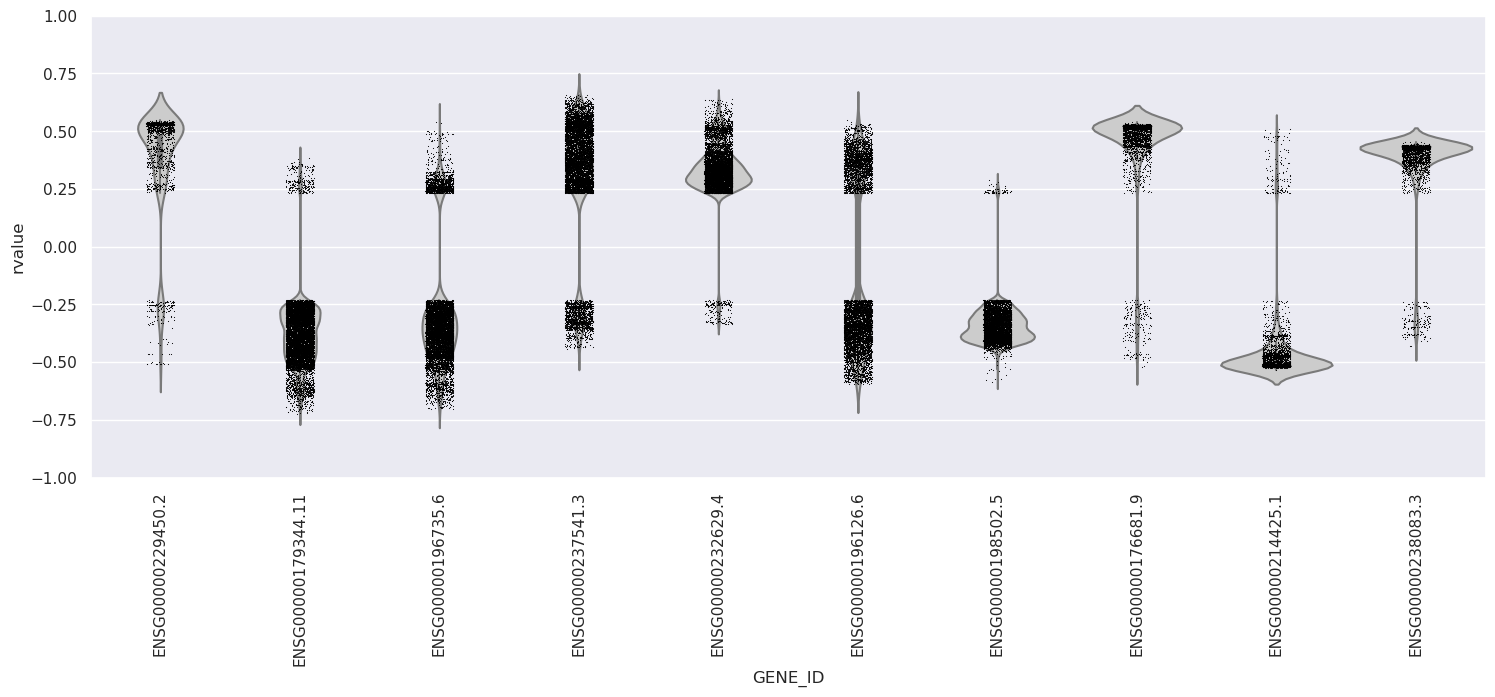

In [32]:
sns.set(rc={'figure.figsize':(18,6)})
sns.violinplot(y='rvalue', x='GENE_ID', data=reference[reference.GENE_ID.isin(genes)], color="0.8")
sns.stripplot(y='rvalue', x='GENE_ID', data=reference[reference.GENE_ID.isin(genes)], color="0.0", size=0.8)
plt.ylim(-1.0, 1.0)
plt.xticks(rotation=90)

One gene where prediction based on SNPs never really works is gene ENSG00000198502.5. Ridge regression using the embedding with optuna optimization of alpha only resulted an rvalue of 0.33, so that didn't really perform better.

In [41]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
optimal = []
for gene in genes:
    y = df[df.gene_id==gene].expression.values
    X = np.stack(df[df.gene_id==gene].embedding.values)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_ridge, n_trials=100)
    optimal.append([study.best_params, study.best_value])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ENSG00000229450.2'),
  Text(1, 0, 'ENSG00000179344.11'),
  Text(2, 0, 'ENSG00000196735.6'),
  Text(3, 0, 'ENSG00000237541.3'),
  Text(4, 0, 'ENSG00000232629.4'),
  Text(5, 0, 'ENSG00000196126.6'),
  Text(6, 0, 'ENSG00000198502.5'),
  Text(7, 0, 'ENSG00000176681.9'),
  Text(8, 0, 'ENSG00000214425.1'),
  Text(9, 0, 'ENSG00000238083.3')])

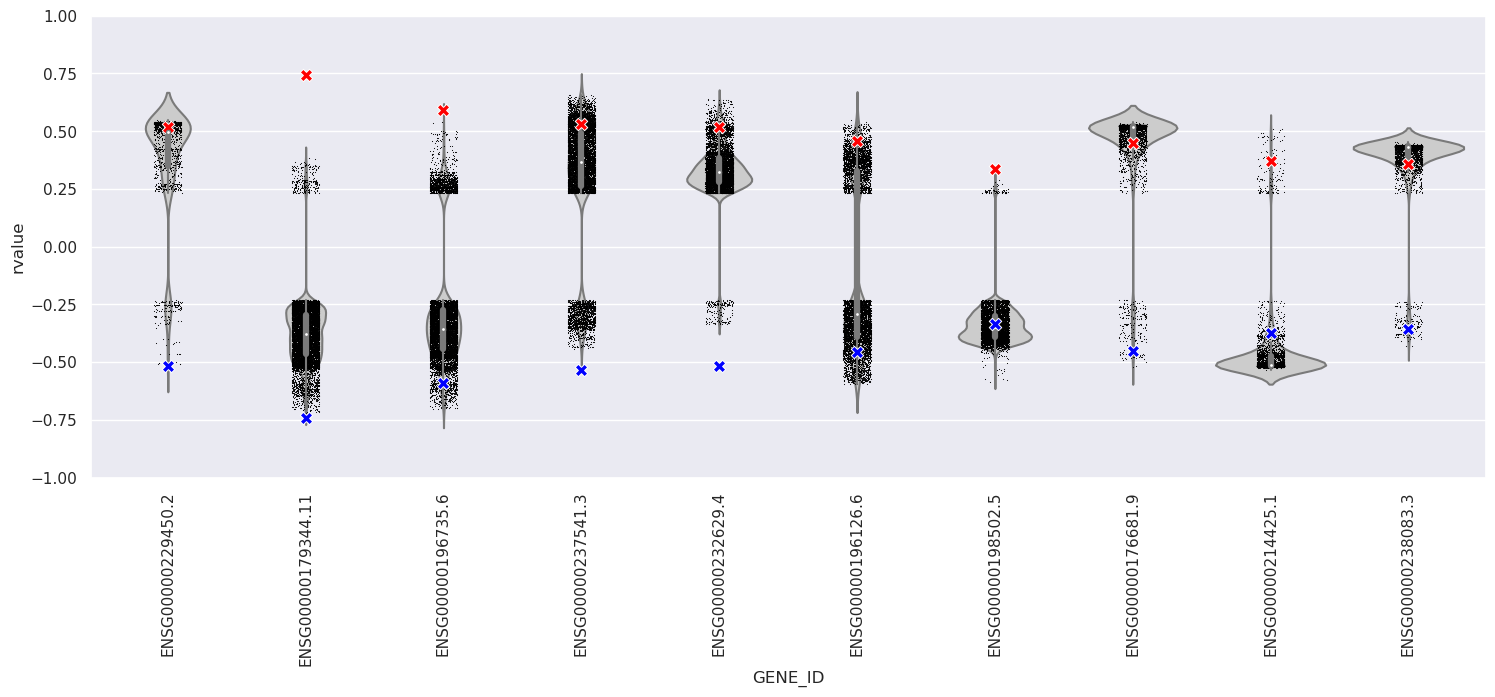

In [63]:
sns.set(rc={'figure.figsize':(18,6)})
sns.violinplot(y='rvalue', x='GENE_ID', data=reference[reference.GENE_ID.isin(genes)], color="0.8", zorder=0)
sns.stripplot(y='rvalue', x='GENE_ID', data=reference[reference.GENE_ID.isin(genes)], color="0.0", size=0.8, zorder=1)
sns.scatterplot(x="gene", y="rvalue", data=pd.DataFrame({"gene": genes, "rvalue": np.array(optimal)[:,1]}), color="red", s=80, marker="X", zorder=2)
sns.scatterplot(x="gene", y="rvalue", data=pd.DataFrame({"gene": genes, "rvalue": -1*np.array(optimal)[:,1]}), color="blue", s=80, marker="X", zorder=3)
plt.ylim(-1.0, 1.0)
plt.xticks(rotation=90)